<a href="https://colab.research.google.com/github/belvdere/NeuralNetworkAssignment/blob/main/Belvedere_Song_Zheng_Yi_Part_B_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question B3 (10 marks)

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [1]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.0 MB/s eta 0:00:00


In [2]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

1.First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [4]:
df = pd.read_csv('hdb_price_prediction.csv')

# Drop columns that are not used
df = df.drop(['full_address', 'nearest_stn'], axis=1)

continuous_vars = ["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"]
categorical_vars = [ "month", "town", "flat_model_type", "storey_range"]

df = df.drop(categorical_vars, axis=1)

train_df = df[df.year < 2020]
val_df = df[df.year == 2020]
test_df = df[df.year == 2021]

# Remove the years once we use it to get the needed DF
train_df = train_df.drop(['year'], axis=1)
val_df = val_df.drop(['year'], axis=1)
test_df = test_df.drop(['year'], axis=1)

In [5]:
train_df

,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,remaining_lease_years,floor_area_sqm,resale_price
0,1.007264,7.006044,0.016807,0.006243,61.333333,44.0,232000.0
1,1.271389,7.983837,0.016807,0.006243,60.583333,67.0,250000.0
2,1.069743,9.090700,0.016807,0.002459,62.416667,67.0,262000.0
3,0.946890,7.519889,0.016807,0.006243,62.083333,68.0,265000.0
4,1.092551,9.130489,0.016807,0.002459,62.416667,67.0,265000.0
...,...,...,...,...,...,...,...
64052,0.823163,14.421823,0.016807,0.000382,67.583333,142.0,580000.0
64053,0.823163,14.421823,0.016807,0.000382,67.583333,146.0,565000.0
64054,0.445869,13.498243,0.016807,0.000968,71.500000,164.0,633000.0
64055,0.552769,13.598257,0.016807,0.000968,71.500000,164.0,788888.0


In [6]:
# Extract labels and convert to Numpy
y_train = train_df['resale_price'].values
X_train = train_df.drop(['resale_price'], axis=1)

y_val = val_df['resale_price'].values
X_val = val_df.drop(['resale_price'], axis=1)

y_test = test_df['resale_price'].values
X_test = test_df.drop(['resale_price'], axis=1)

X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

In [7]:

# Put in terms of tensor
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float).view(-1, 1)

# Convert validation data to tensors
X_val = torch.tensor(X_val, dtype=torch.float)
y_val = torch.tensor(y_val, dtype=torch.float).view(-1, 1)

# Convert test data to tensors
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float).view(-1, 1)

2.Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def preprocess_dataset(df_train, df_test):

    standard_scaler = preprocessing.StandardScaler()
    df_train_scaled = standard_scaler.fit_transform(df_train)

    df_test_scaled = standard_scaler.transform(df_test)

    return df_train_scaled, df_test_scaled

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

In [9]:
def init_dataloader(x_train, y_train, x_val, y_val, batch_size=1024, shuffle=True):

    train_data = CustomDataset(x_train, y_train)
    val_data = CustomDataset(x_val, y_val)

    training_dataloader = DataLoader(train_data, batch_size, shuffle)
    validation_dataloader = DataLoader(val_data, batch_size, shuffle)

    return training_dataloader, validation_dataloader

In [10]:
## Model
class FFN(nn.Module):
    def __init__(self, no_features, no_hidden, no_output):
        super().__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Linear(no_hidden, no_output),
        )

    def forward(self, x):
        return self.relu_stack(x)

In [11]:
# Train and Test loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    for batch, (x, y) in enumerate(dataloader):
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= size
    return train_loss

def val_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss = 0
    with torch.no_grad():
        for x, y, in dataloader:
            pred = model(x)

            val_loss += loss_fn(pred, y).item()
    val_loss /= size
    return val_loss

In [12]:
def training(model, train_dataloader, val_dataloader, optimizer, loss_fn, early_stopper, no_epochs):
    training_loss = []
    validation_loss = []
    for epoch in range(no_epochs):
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        val_loss = val_loop(val_dataloader, model, loss_fn)

        training_loss.append(train_loss)
        validation_loss.append(val_loss)

        if epoch % 10 == 0:
            print("Epoch:", epoch)
            print("Train Loss:", train_loss, "| Validation Loss:", val_loss)

        if early_stopper.early_stop(val_loss):
            print("Early Stopping", epoch)
            break

    return training_loss, validation_loss

In [14]:
train_dataloader, val_dataloader = init_dataloader(X_train, y_train, X_val, y_val)
no_features = len(X_train[0])
no_hidden = 5
no_output = 1
lr = 0.001
no_epochs = 200
batch_size = 1024

model = FFN(no_features, no_hidden, no_output)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
early_stopper = EarlyStopper(patience=3, min_delta=100000)

train_loss, val_loss = training(model, train_dataloader, val_dataloader, optimizer, loss_fn, early_stopper, no_epochs)

<ipython-input-8-6c29ccf9a803>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float)
<ipython-input-8-6c29ccf9a803>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)


Epoch: 0
Train Loss: 212755660.85754874 | Validation Loss: 225330712.88294086
Epoch: 10
Train Loss: 193340763.06689355 | Validation Loss: 201264428.65971777
Epoch: 20
Train Loss: 57724407.75933934 | Validation Loss: 55812693.19058036
Epoch: 30
Train Loss: 15559187.334779961 | Validation Loss: 15141224.879509287
Epoch: 40
Train Loss: 15229728.726852646 | Validation Loss: 14698949.427358126
Epoch: 50
Train Loss: 14926948.166788954 | Validation Loss: 14413705.27345258
Epoch: 60
Train Loss: 14587534.760853615 | Validation Loss: 14117170.545532536
Epoch: 70
Train Loss: 14209271.555520864 | Validation Loss: 13758588.04135032
Epoch: 80
Train Loss: 13781369.61568603 | Validation Loss: 13411687.781409513
Epoch: 90
Train Loss: 13359194.495402532 | Validation Loss: 13068505.687298931
Epoch: 100
Train Loss: 12942221.078352092 | Validation Loss: 12685528.457427187
Epoch: 110
Train Loss: 12480501.769111885 | Validation Loss: 12310360.78136662
Epoch: 120
Train Loss: 12022372.718297767 | Validation Lo

In [15]:
from sklearn.metrics import mean_squared_error

prediction = model(X_test)
error = np.sqrt(mean_squared_error(prediction.detach().numpy(), y_test.detach().numpy()))
print("Model Test Error:", error)

Model Test Error: 102938.9


In [29]:
import matplotlib.pylab as plt

def scores(model, X_test, X_train, y_test, y_train):
    sal = Saliency(model)
    ixg = InputXGradient(model)
    ig = IntegratedGradients(model)
    gs = GradientShap(model)
    fa = FeatureAblation(model)


    sal_attr_test = sal.attribute(X_test)
    ixg_attr_test = ixg.attribute(X_test)
    baseline = torch.zeros_like(X_test)
    ig_attr_test = ig.attribute(X_test, baselines=baseline, n_steps=50)
    gs_attr_test = gs.attribute(X_test, X_train)
    fa_attr_test = fa.attribute(X_test)


    x_axis_data = np.arange(X_test.shape[1])
    x_axis_data_labels = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality',
        'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']

    sal_attr_test_sum = sal_attr_test.detach().numpy().sum(0)
    sal_attr_test_norm_sum = sal_attr_test_sum / np.linalg.norm(sal_attr_test_sum, ord=1)

    ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
    ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

    ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

    gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
    gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

    fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
    fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)


    width = 0.14
    legends = ['Saliency', 'InputXGradient', 'IntegratedGradients', 'GradientShap', 'FeatureAblation']

    plt.figure(figsize=(20, 10))

    ax = plt.subplot()
    ax.set_title('Comparing input feature importances across multiple algorithms')
    ax.set_ylabel('Attributions')

    FONT_SIZE = 16
    plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
    plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
    plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
    plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend


    ax.bar(x_axis_data, sal_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
    ax.bar(x_axis_data + width, ixg_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
    ax.bar(x_axis_data + 2 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
    ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
    ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
    ax.autoscale_view()
    plt.tight_layout()

    ax.set_xticks(x_axis_data + 0.5)
    ax.set_xticklabels(x_axis_data_labels)

    plt.legend(legends, loc=3)
    plt.show()

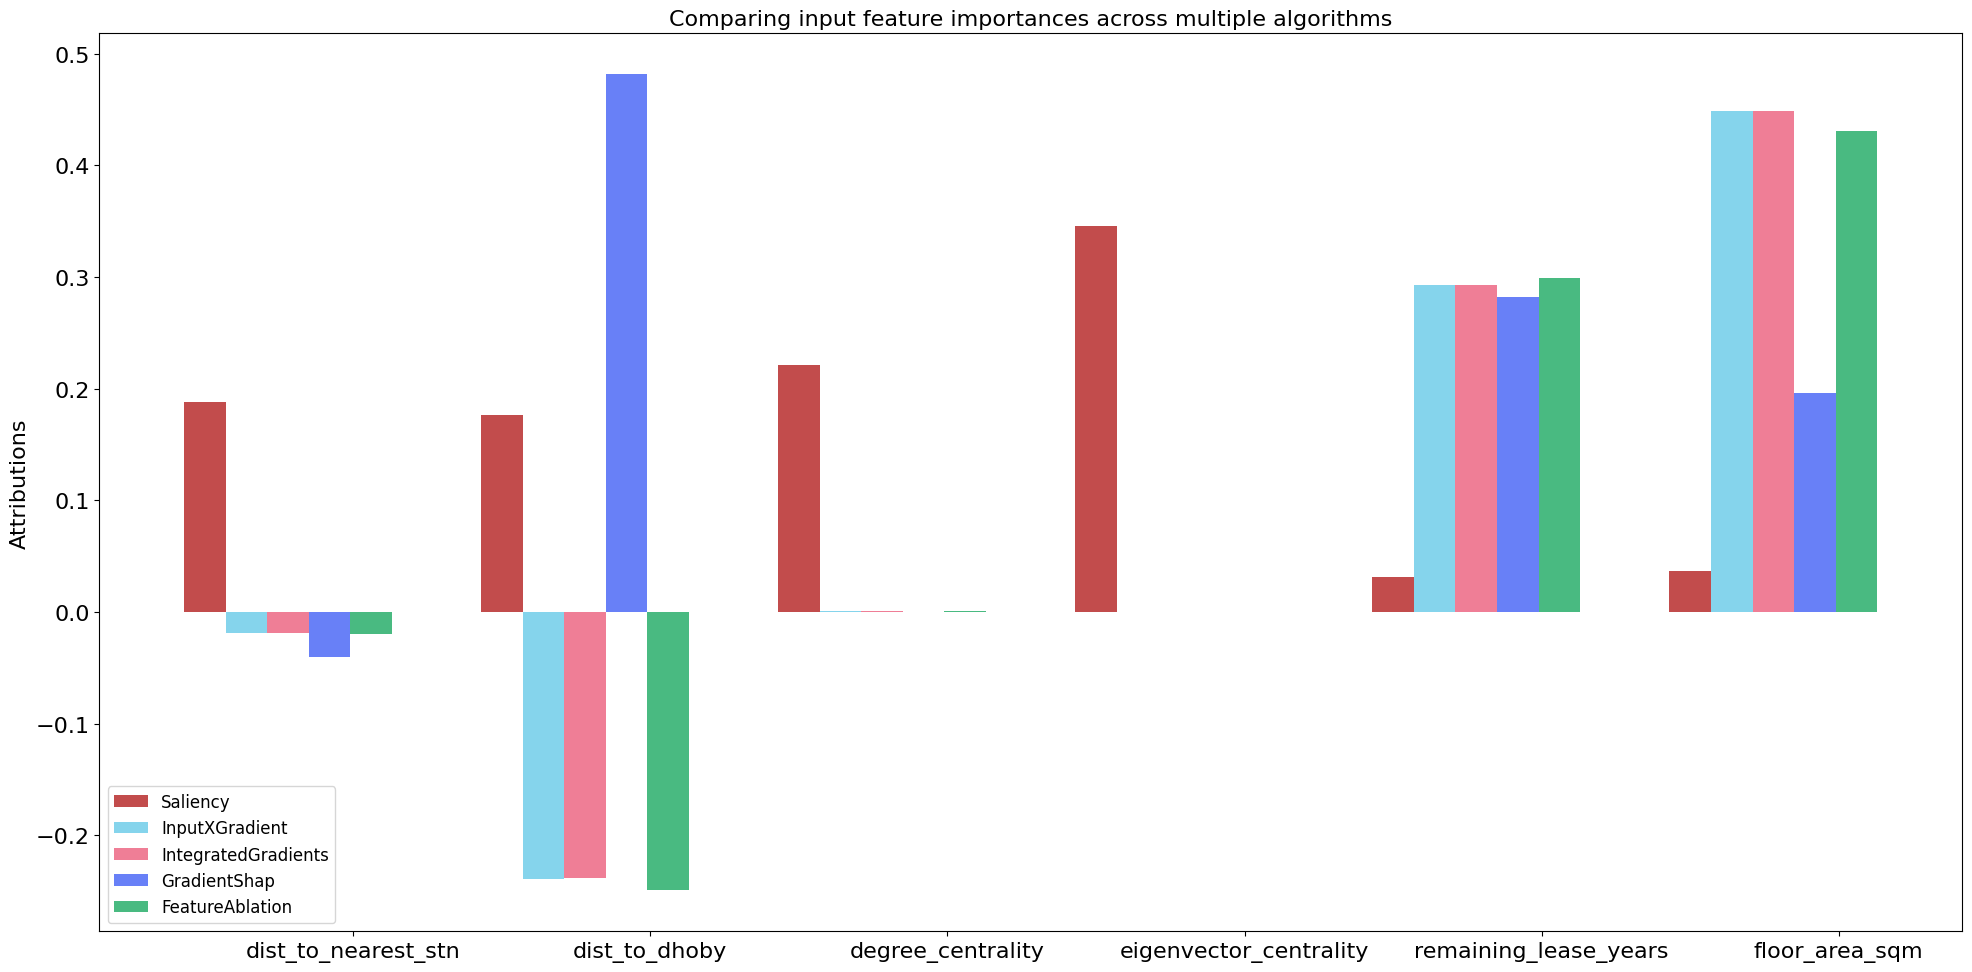

In [30]:
scores(model, X_test, X_train, y_test, y_train)

3.Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [18]:
# Extract labels and convert to Numpy
y_train_scaled = train_df['resale_price'].values
X_train_scaled = train_df.drop(['resale_price'], axis=1)

y_val_scaled = val_df['resale_price'].values
X_val_scaled = val_df.drop(['resale_price'], axis=1)

y_test_scaled = test_df['resale_price'].values
X_test_scaled = test_df.drop(['resale_price'], axis=1)

X_train_scaled = X_train_scaled.to_numpy()
X_val_scaled = X_val_scaled.to_numpy()
X_test_scaled = X_test_scaled.to_numpy()

# Scaling
X_train_scaled, X_val_scaled = preprocess_dataset(X_train_scaled, X_val_scaled)
_, X_test_scaled = preprocess_dataset(X_train_scaled, X_test_scaled)

# Put in terms of tensor
y_train_scaled = torch.tensor(y_train_scaled, dtype=torch.float).view(-1, 1)
X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float)

y_val_scaled = torch.tensor(y_val_scaled, dtype=torch.float).view(-1, 1)
X_val_scaled = torch.tensor(X_val_scaled, dtype=torch.float)

y_test_scaled = torch.tensor(y_test_scaled, dtype=torch.float).view(-1, 1)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float)


In [19]:
train_scaled_loader, val_scaled_loader  = init_dataloader(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)
no_features = len(X_train_scaled[0])

model_scaled = FFN(no_features, no_hidden, no_output)
optimizer = torch.optim.Adam(model_scaled.parameters(), lr=lr)
loss_fn = nn.MSELoss()
early_stopper = EarlyStopper(patience=3, min_delta=100000)

train_loss_scaled, val_loss_scaled = training(model_scaled, train_scaled_loader, val_scaled_loader, optimizer, loss_fn, early_stopper, no_epochs)

<ipython-input-8-6c29ccf9a803>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float)
<ipython-input-8-6c29ccf9a803>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)


Epoch: 0
Train Loss: 212741427.90177497 | Validation Loss: 225322163.51735082
Epoch: 10
Train Loss: 212329228.23310488 | Validation Loss: 224909298.38356283
Epoch: 20
Train Loss: 206570815.05983734 | Validation Loss: 218583104.48041865
Epoch: 30
Train Loss: 187840641.19693398 | Validation Loss: 198794118.81370908
Epoch: 40
Train Loss: 153246432.7838019 | Validation Loss: 162838446.56492087
Epoch: 50
Train Loss: 109348279.14488658 | Validation Loss: 117057925.95719127
Epoch: 60
Train Loss: 67262052.7502693 | Validation Loss: 72512652.33715095
Epoch: 70
Train Loss: 36579148.831571884 | Validation Loss: 39668396.95071419
Epoch: 80
Train Loss: 20888402.73031831 | Validation Loss: 22642629.141852185
Epoch: 90
Train Loss: 15379605.11519428 | Validation Loss: 16451051.729078196
Epoch: 100
Train Loss: 13038455.337714847 | Validation Loss: 13945948.723544803
Epoch: 110
Train Loss: 11272655.938804502 | Validation Loss: 12149391.038476387
Epoch: 120
Train Loss: 9736531.010069158 | Validation Loss

In [20]:
pred = model_scaled(X_test_scaled)
error = np.sqrt(mean_squared_error(pred.detach().numpy(), y_test_scaled.detach().numpy()))
print("Scaled Test Error", error)

Scaled Test Error 17060802.0


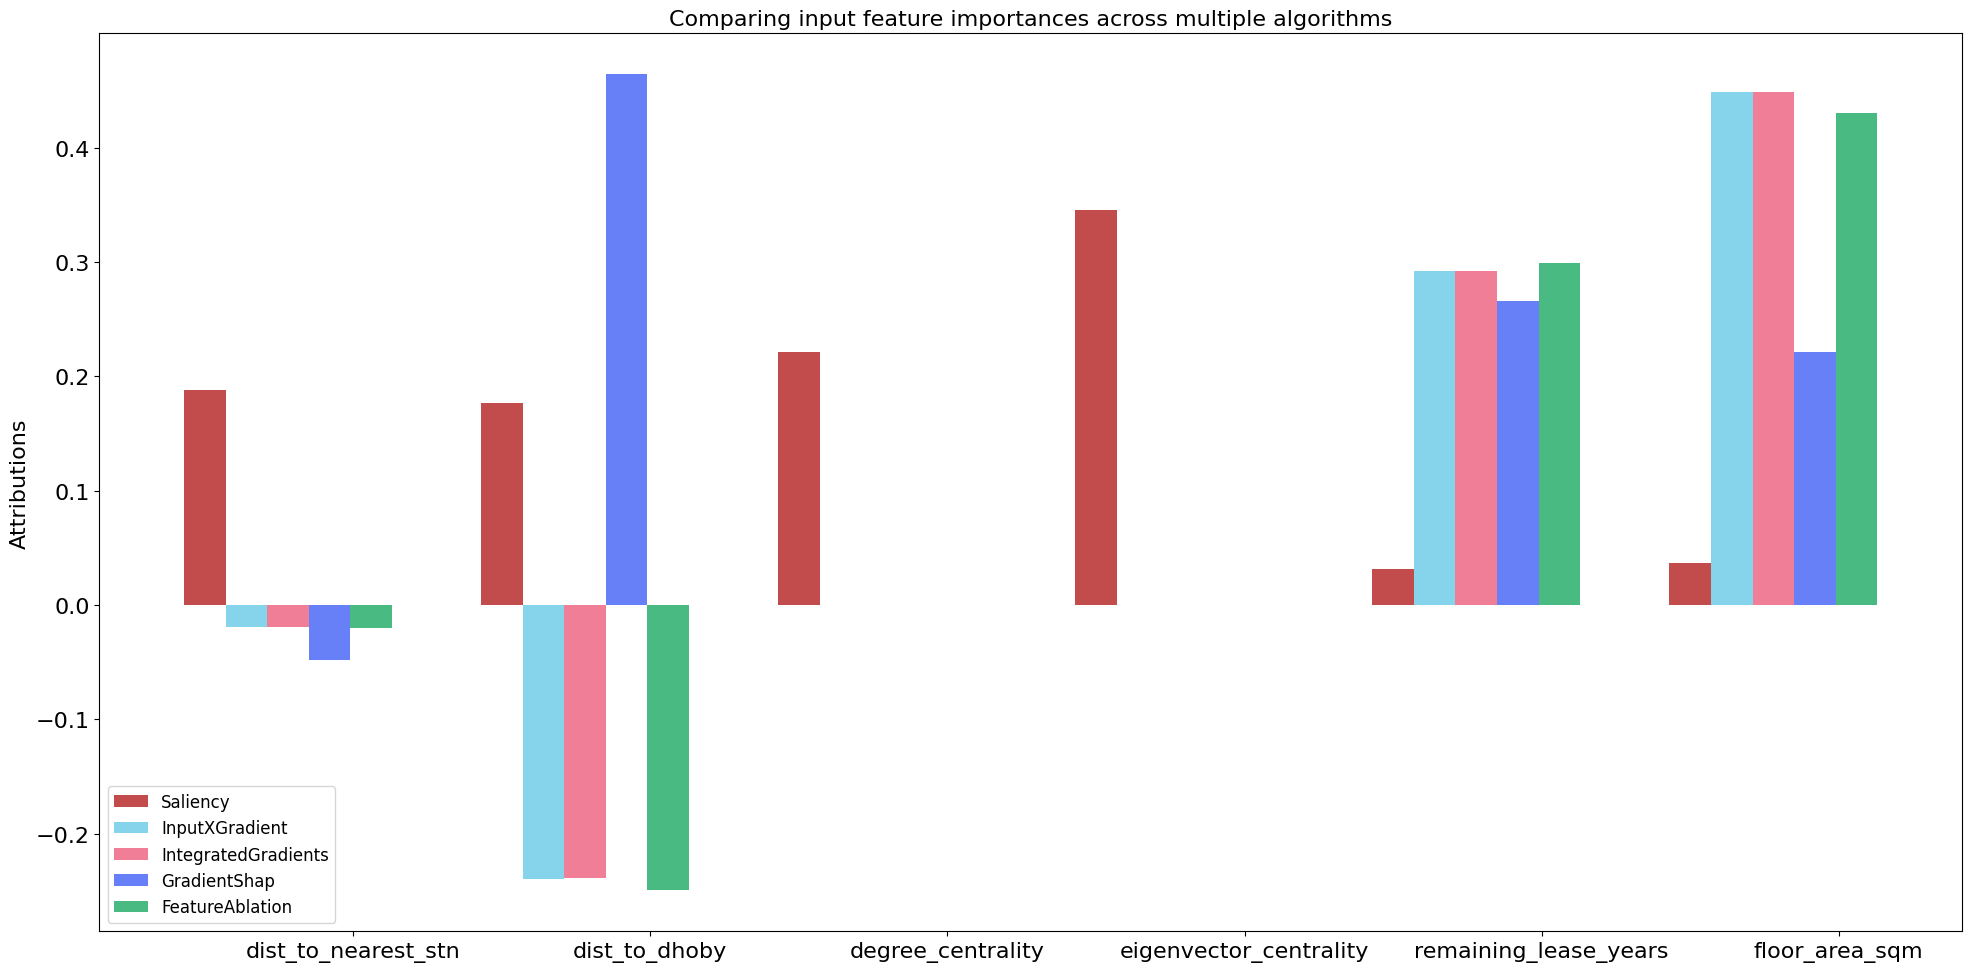

In [31]:
# Model with not scaled inputs
scores(model, X_test, X_train, y_test, y_train)

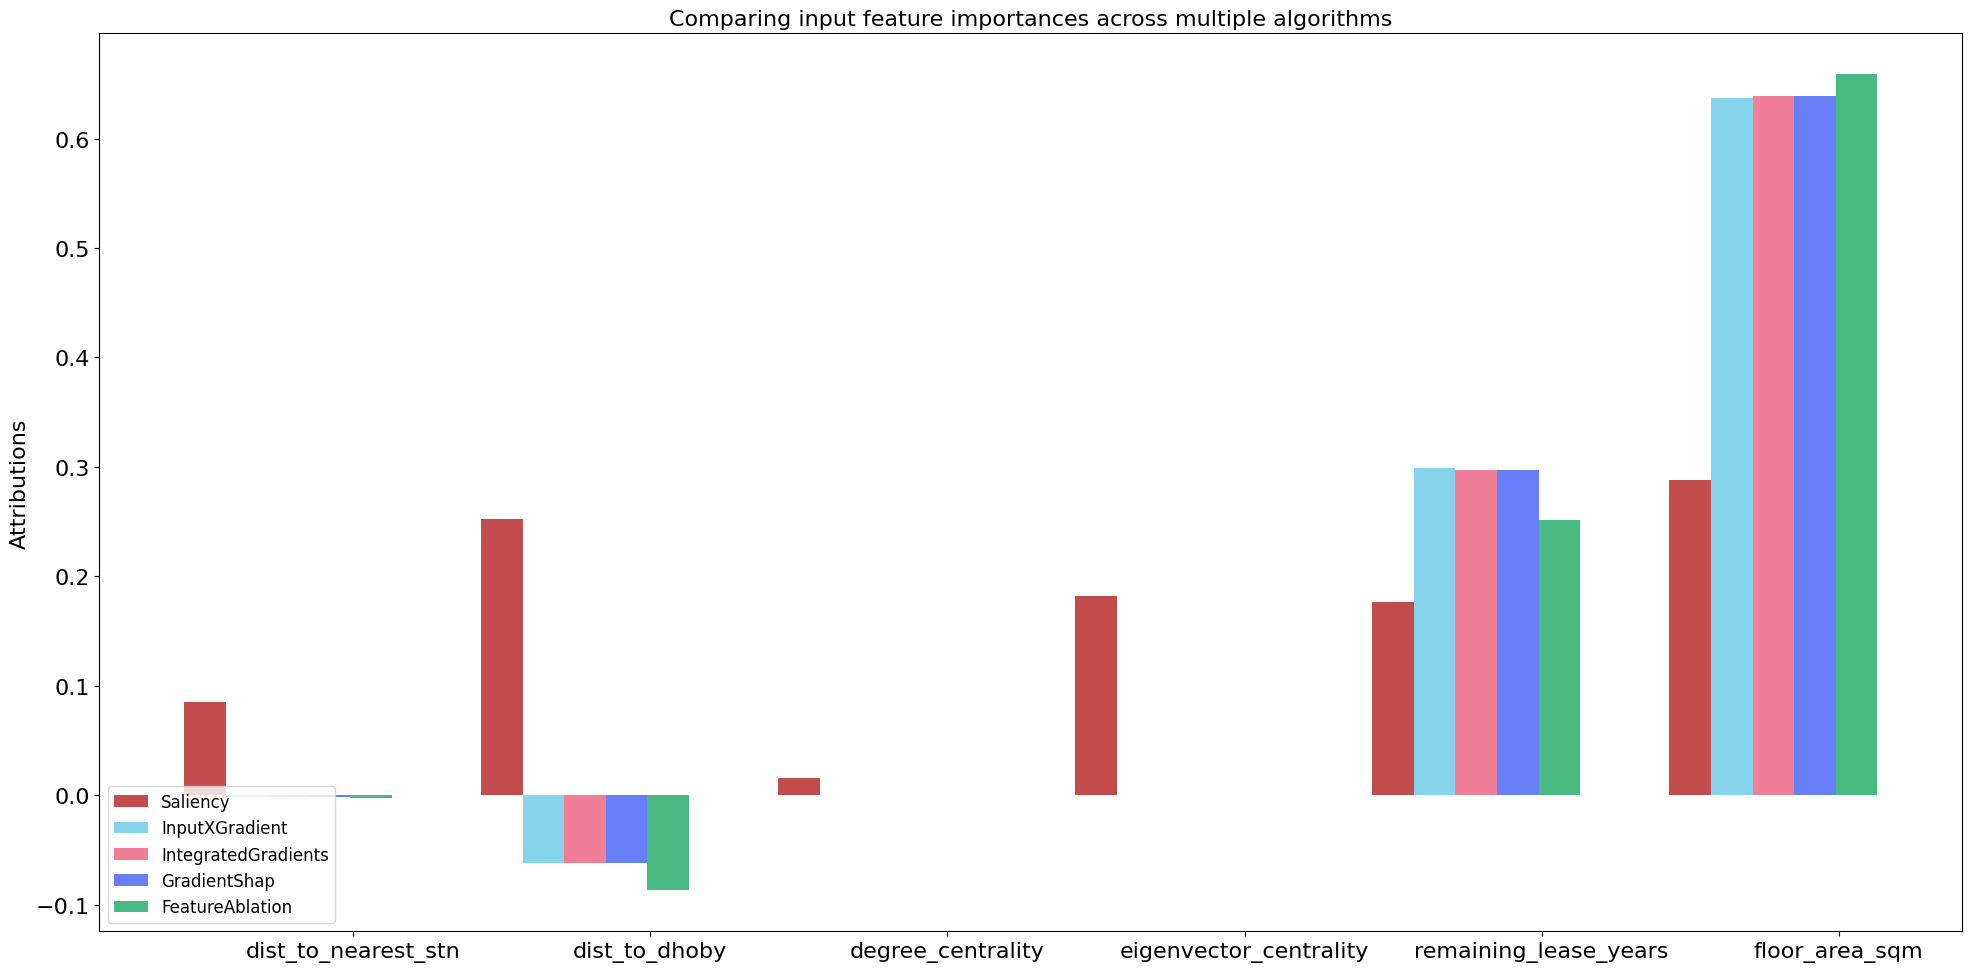

In [32]:
# model with scaled inputs
scores(model_scaled, X_test_scaled, X_train_scaled, y_test_scaled, y_train_scaled)

QN: State your observations with respect to GradientShap and explain why it has occurred.

From both of the diagram, remaing_lease_years and floor_area_sqm have high feature attributions

meanwhile, the most significant difference with respect to GradientShap is dist_to_dhoby.
- In the model trained non-scaled data, the dis_to_dhoby feature has the highest attributions whereas, the model trained with scaled data has negative attributions.

This may be because how GradientShap works. It works by estimating the contribution of each feature based on the gradient of the model's output with respect to the feature. If features have very different scales, the unscale feautre with a large range can dominate the gradient because a small change in that feature may result in a much larger change in the model ouput.  

This make sense in the case of dist_to_dhoby given that since we are calculating the distance to dhoby ghout (the center of singapore) which can take the range of half the length / height of singapore.

Scaling the inputs normalizes all features to the same range (e.g., StandardScaler scales all features to have mean 0 and variance 1). This ensures that the gradients are not biased towards features with larger ranges, and GradientShap can more accurately assess the importance of each feature based on how much they contribute to the predictions, rather than their raw scale.


Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

4.Why did Saliency produce scores similar to IG?


In [ ]:
# YOUR ANSWER HERE


Saliency computes the gradient of the model's output with respect to the input features to indentify which features have the most immediate impact on the prediciton by measuring local sensitivity

IG calculates the average gradient along the path from the baseline input (usually zero and for our case set to zero) to the actual input, providing a more robust and comprehensive measure of feature importance.

Saliency producec scores similar to IG is because both methods are graident-based and rely on computing how changes in input features affects the model's output.

They both produce similar scores when the input feature is approximately linear or the gradients are smooth and consistent.

From our above plots, the feature remaining_lease_years is similar in scores given the nature of remaining_lease_year which offen have a direct relationship with the resale price.

Whereas for other features such as dist_to_nearest_station and dist_to_dhbody do not have similar score which could be due to the non-linearly of the relationship with the output.

5.Why did Input x Gradients give the same attribution scores as IG?


In [ ]:
# YOUR ANSWER HERE

Input X Graident computes the attributions by multiplying the input value of each feature by the gradient of the model's output with respect to that input. This mehtod captures the local sensitivity of the output to each feature, scaled by the feature's value

And as mention above, IG calculates the average gradient along the path from the baseline input (set to zero for our case) to the actual input, providing a more robust and comprehensive measure of the feature important


From both plot, Input X Gradieent give the same attribution scores as IG as IG esstentially averages the gradient from 0 (baseline) to the actual input. If the path has consistnt gradients (for both linear or near-linear model), the average gradient closely mathes the gradient at the input.

When we multiple this average gradient by the input value, it become almost identicial to the Input X Gradient method which directly multiplies the gradient at the input by the input value